Using **cohort analysis** to see customers' **churn or return** pattern  

Inspired by <a href="{https://practicaldatascience.co.uk/data-science/how-to-perform-a-customer-cohort-analysis-in-pandas}">Practical Data Science: How to perform a customer cohort analysis in Pandas</a>  
Dataset from <a href="{https://archive.ics.uci.edu/ml/datasets/Online+Retail}">UCI Machine Learning Repository: Online Retail</a>

In [1]:
# import packages

import pandas as pd
import numpy as np
import operator as op
import matplotlib.pyplot as plt
import seaborn as sns


# Load Dataset

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df['CustomerID'] = df.CustomerID.fillna('Unknown')
df.drop('Description', axis=1, inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Calculate the order cohort and acquisition cohort

In [7]:
def get_cohort(df, period='M'):
    
    df = df[['CustomerID','InvoiceNo','InvoiceDate']].drop_duplicates()
    df = df.assign(acquisition_cohort = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period(period))
    df = df.assign(order_cohort = df['InvoiceDate'].dt.to_period(period))
    
    return df

In [8]:
cohort = get_cohort(df, period='Q')
cohort.head()

,CustomerID,InvoiceNo,InvoiceDate,acquisition_cohort,order_cohort
0,17850.0,536365,2010-12-01 08:26:00,2010Q4,2010Q4
7,17850.0,536366,2010-12-01 08:28:00,2010Q4,2010Q4
9,13047.0,536367,2010-12-01 08:34:00,2010Q4,2010Q4
21,13047.0,536368,2010-12-01 08:34:00,2010Q4,2010Q4
25,13047.0,536369,2010-12-01 08:35:00,2010Q4,2010Q4


# Calculate the retention for each cohort

In [9]:
def get_retention(df, period='M'):

    df = get_cohort(df, period).groupby(['acquisition_cohort', 'order_cohort'])\
                                .agg(customers=('CustomerID', 'nunique')) \
                                .reset_index(drop=False)
    df['periods'] = (df.order_cohort - df.acquisition_cohort).apply(op.attrgetter('n'))

    return df

In [10]:
retention = get_retention(df, period='M')
retention.head()

,acquisition_cohort,order_cohort,customers,periods
0,2010-12,2010-12,949,0
1,2010-12,2011-01,363,1
2,2010-12,2011-02,318,2
3,2010-12,2011-03,368,3
4,2010-12,2011-04,342,4


# Create cohort matrix

In [11]:
def get_cohort_matrix(df, period='M', percentage=False):
    
    df = get_retention(df, period).pivot_table(index = 'acquisition_cohort',
                                               columns = 'periods',
                                               values = 'customers')
    
    if percentage:
        df = df.divide(df.iloc[:,0], axis=0)*100
    
    return df

In [12]:
# Monthly cohort
matrix_m = get_cohort_matrix(df, 'M', percentage=True)
matrix_m.head()

periods,0,1,2,3,4,5,6,7,8,9,10,11,12
acquisition_cohort,,,,,,,,,,,,,
2010-12,100.0,38.250790,33.508957,38.777661,36.037935,39.726027,38.040042,35.511064,35.511064,39.515279,37.407798,50.052687,27.502634
2011-01,100.0,23.990499,28.266033,24.228029,32.779097,29.928741,26.128266,25.653207,31.116390,34.679335,36.817102,14.964371,NaN
2011-02,100.0,24.736842,19.210526,27.894737,26.842105,24.736842,25.526316,28.157895,25.789474,31.315789,9.210526,NaN,NaN
2011-03,100.0,19.090909,25.454545,21.818182,23.181818,17.727273,26.363636,23.863636,28.863636,8.863636,NaN,NaN,NaN
2011-04,100.0,22.742475,22.073579,21.070234,20.735786,23.745819,23.076923,26.086957,8.361204,NaN,NaN,NaN,NaN


In [13]:
# Quarterly cohort
matrix_q = get_cohort_matrix(df, 'Q', percentage=True)
matrix_q.head()

periods,0,1,2,3,4
acquisition_cohort,,,,,
2010Q4,100.0,60.273973,60.906217,60.063224,64.910432
2011Q1,100.0,51.087832,49.959710,49.153908,NaN
2011Q2,100.0,43.173432,44.403444,NaN,NaN
2011Q3,100.0,45.884146,NaN,NaN,NaN
2011Q4,100.0,NaN,NaN,NaN,NaN


In [14]:
# Annual cohort
matrix_a = get_cohort_matrix(df, 'Y', percentage=True)
matrix_a.head()

periods,0,1
acquisition_cohort,,
2010,100.0,86.512118
2011,100.0,NaN


In [15]:
# Annual cohort
matrix_a = get_cohort_matrix(df, 'Y', percentage=False)
matrix_a.head()

periods,0,1
acquisition_cohort,,
2010,949.0,821.0
2011,3424.0,NaN


# Create cohort analysis heatmap

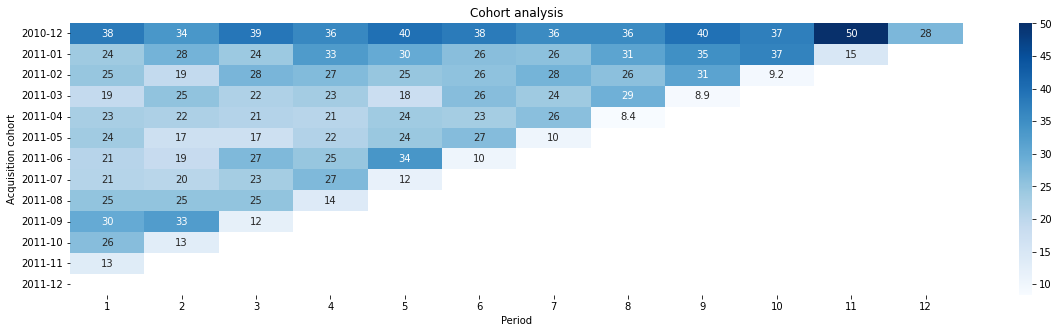

In [16]:
del matrix_m[0]

plt.subplots(figsize=(20, 5))

monthly_sessions = sns.heatmap(matrix_m, annot=True, cmap='Blues')

plt.title('Cohort analysis')
plt.xlabel('Period')
plt.ylabel('Acquisition cohort')
plt.show()

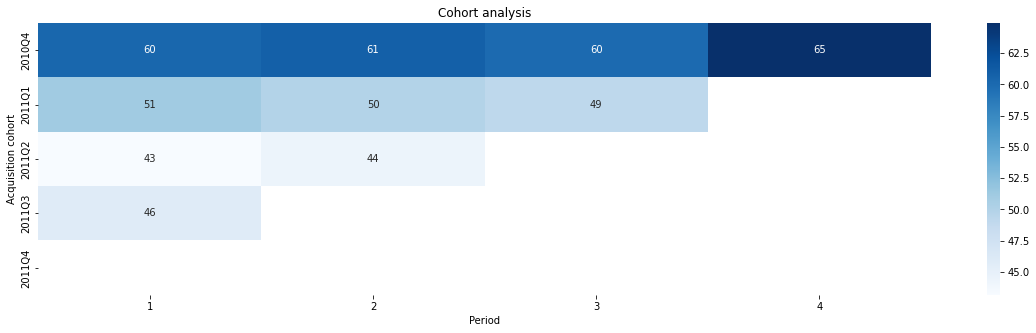

In [17]:
del matrix_q[0]

plt.subplots(figsize=(20, 5))

monthly_sessions = sns.heatmap(matrix_q, annot=True, cmap='Blues')

plt.title('Cohort analysis')
plt.xlabel('Period')
plt.ylabel('Acquisition cohort')
plt.show()